In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
df = pd.read_csv('/Users/starsrain/2025_concord/yieldCurve_augmenting/raw_data/data_1021-v1.csv')
lookback_days = 30

In [17]:
def prepare_df_strict(df):
    """Prepare dataframe with strict data cleaning"""
    df = df.copy()
    df = df[df['PaymentStatus'] != 'R']
    # Convert date columns
    date_cols = ['OriginationDate', 'DueDate']
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Drop rows with missing critical fields
    critical_fields = ['LoanID', 'OriginatedAmount', 'InstallmentNumber']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    dropped = initial_count - len(df)
    if dropped > 0:
        print(f"[prepare] Dropped {dropped} rows with missing critical fields")

    
    # Create cohort from origination date
    df['Cohort'] = df['OriginationDate'].dt.to_period('M').astype(str)
    
    # Ensure CustType exists
    if 'CustType' not in df.columns:
        df['CustType'] = 'Unknown'
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['LoanID', 'InstallmentNumber', 'DueDate', 'PaidOffPaymentAmount'])
    after_dedup = len(df)
    if before_dedup != after_dedup:
        print(f"[prepare] Removed {before_dedup - after_dedup} duplicate records")

    
    return df

### by InstallmentNumber for different customer types (last 30 days)

[prepare] Removed 7600 duplicate records
[lookback] Kept 17426/439198 rows within 30d before DueDate


/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1081958685.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1081958685.py:86: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
/var/fol

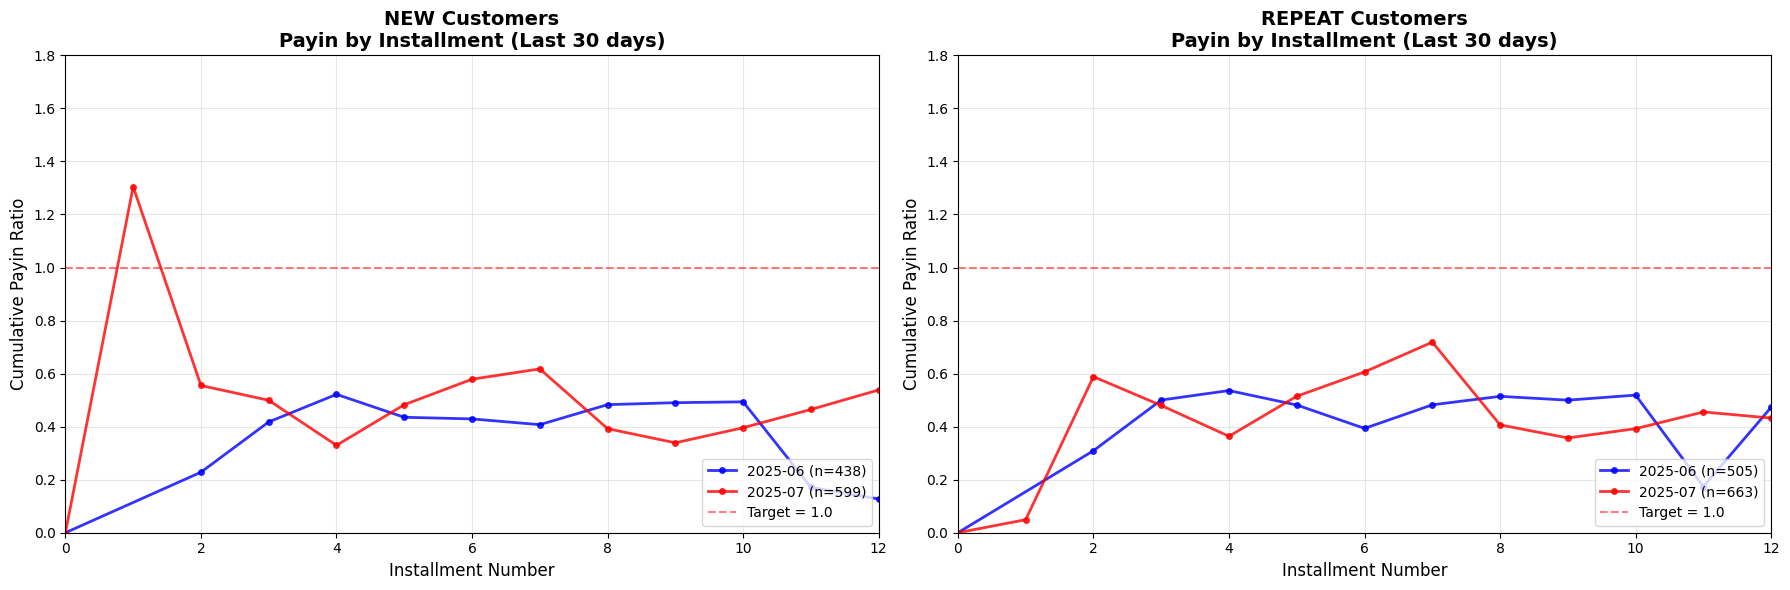

PAYIN SUMMARY BY CUSTOMER TYPE (Last 30 Days)

NEW Customers:
------------------------------
  2025-06: 438 loans, $0.3M total, $714 avg
    Installment  2: 0.228
    Installment  3: 0.402
    Installment  6: 0.465
    Installment 12: 0.539
  2025-07: 599 loans, $0.4M total, $745 avg
    Installment  1: 1.305
    Installment  2: 0.597
    Installment  3: 0.514
    Installment  6: 0.561
    Installment 12: 0.614

REPEAT Customers:
------------------------------
  2025-06: 505 loans, $0.4M total, $866 avg
    Installment  2: 0.309
    Installment  3: 0.465
    Installment  6: 0.471
    Installment 12: 0.580
  2025-07: 663 loans, $0.6M total, $873 avg
    Installment  1: 0.049
    Installment  2: 0.565
    Installment  3: 0.501
    Installment  6: 0.589
    Installment 12: 0.635


In [18]:
# Create payin plots by InstallmentNumber for different customer types (last 30 days)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# Add the missing helper functions


def filter_lookback(df, lookback_days=30):
    """Filter to include only loans with DueDate in the last N days"""
    if 'DueDate' not in df.columns:
        print("[lookback] No DueDate column found, returning all data")
        return df
    
    # Calculate the cutoff date
    cutoff_date = datetime.now() - timedelta(days=lookback_days)
    
    # Filter the data
    initial_count = len(df)
    df_filtered = df[df['DueDate'] >= cutoff_date].copy()
    final_count = len(df_filtered)
    
    print(f"[lookback] Kept {final_count}/{initial_count} rows within {lookback_days}d before DueDate")
    
    return df_filtered

def create_payin_plots_by_customer_type(df, cohorts, lookback_days=30, cap=1.70):
    """
    Create payin plots by InstallmentNumber for different customer types
    - Only include loans with DueDate in the last 30 days
    - Separate plots for NEW, REPEAT, and MB+Monthly combined
    """
    
    # Prepare data
    df_prepared = prepare_df_strict(df)
    df_filtered = filter_lookback(df_prepared, lookback_days=lookback_days)
    
    # Define customer type groupings
    customer_mappings = {
        'NEW': ['NEW'],
        'REPEAT': ['REPEAT']
    }
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Colors for cohorts
    cohort_colors = {
        '2025-06': 'blue',
        '2025-07': 'red',
        '2025-08': 'green',
        '2025-09': 'orange',
        '2025-10': 'purple'
    }
    
    for idx, (plot_title, cust_types) in enumerate(customer_mappings.items()):
        ax = axes[idx]
        
        for cohort in cohorts:
            # Filter data for this cohort and customer types
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            if plot_title != 'MB+Monthly':
                cohort_data = cohort_data[cohort_data['CustType'].isin(cust_types)]
            else:
                # For MB+Monthly, combine both types
                cohort_data = cohort_data[cohort_data['CustType'].isin(cust_types)]
            
            if cohort_data.empty:
                continue
                
            # Calculate payin curve by installment
            loan_count = cohort_data['LoanID'].nunique()
            
            # Aggregate payments by loan and installment
            per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                             .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                  OriginatedAmount=('OriginatedAmount', 'first')))
            
            # Calculate cumulative payments per loan
            per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
            per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
            per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
            
            # Calculate weighted average payin ratio by installment
            installment_curve = (per_installment.groupby('InstallmentNumber')
                               .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
                               .reset_index(name='PayinRatio'))
            installment_curve.columns = ['InstallmentNumber', 'PayinRatio']
            
            # Add origin point if not present
            if not (installment_curve['InstallmentNumber'] == 0).any():
                origin = pd.DataFrame({'InstallmentNumber': [0], 'PayinRatio': [0.0]})
                installment_curve = pd.concat([origin, installment_curve], ignore_index=True)
            
            installment_curve = installment_curve.sort_values('InstallmentNumber').reset_index(drop=True)
            
            # Plot the curve
            color = cohort_colors.get(cohort, 'black')
            ax.plot(installment_curve['InstallmentNumber'], installment_curve['PayinRatio'],
                   color=color, linewidth=2, marker='o', markersize=4,
                   label=f'{cohort} (n={loan_count:,})', alpha=0.8)
        
        # Formatting for each subplot
        ax.set_xlabel('Installment Number', fontsize=12)
        ax.set_ylabel('Cumulative Payin Ratio', fontsize=12)
        ax.set_title(f'{plot_title} Customers\nPayin by Installment (Last {lookback_days} days)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(left=0)
        ax.set_ylim(0.0, cap + 0.1)
        
        # Add target line
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Target = 1.0')
        
        # Set reasonable x-axis limits (up to installment 12 typically)
        max_installment = 12
        ax.set_xlim(0, max_installment)
        ax.set_xticks(range(0, max_installment + 1, 2))
        
        # Legend
        ax.legend(fontsize=10, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("PAYIN SUMMARY BY CUSTOMER TYPE (Last 30 Days)")
    print("="*60)
    
    for plot_title, cust_types in customer_mappings.items():
        print(f"\n{plot_title} Customers:")
        print("-" * 30)
        
        for cohort in cohorts:
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['CustType'].isin(cust_types)]
            
            if not cohort_data.empty:
                loan_count = cohort_data['LoanID'].nunique()
                total_orig = cohort_data.groupby('LoanID')['OriginatedAmount'].first().sum()
                avg_orig = total_orig / loan_count if loan_count > 0 else 0
                
                # Calculate payin at key installments
                per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                                 .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                      OriginatedAmount=('OriginatedAmount', 'first')))
                
                per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
                per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
                per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
                
                print(f"  {cohort}: {loan_count:,} loans, ${total_orig/1000000:.1f}M total, ${avg_orig:,.0f} avg")
                
                # Show payin at key installments
                key_installments = [1, 2, 3, 6, 12]
                for inst in key_installments:
                    inst_data = per_installment[per_installment['InstallmentNumber'] <= inst]
                    if not inst_data.empty:
                        weighted_payin = np.average(inst_data.groupby('LoanID')['PayinRatio'].max(), 
                                                  weights=inst_data.groupby('LoanID')['OriginatedAmount'].first())
                        print(f"    Installment {inst:2d}: {weighted_payin:.3f}")

# Run the analysis
create_payin_plots_by_customer_type(df, cohorts=["2025-06", "2025-07"], lookback_days=30, cap=1.70)

### examples of July 2025 loans with recent due dates & distributions of installmentNumbers

In [19]:
# Debug: Show examples of July 2025 loans with recent due dates
df_prepared = prepare_df_strict(df)
df_filtered = filter_lookback(df_prepared, lookback_days=30)

# Filter for July 2025 cohort
july_loans = df_filtered[df_filtered['Cohort'] == '2025-07'].copy()

if not july_loans.empty:
    print("EXAMPLES: July 2025 Loans with Installments Due in Last 30 Days")
    print("="*70)
    
    # Show sample loans with their installment schedule
    sample_loans = july_loans['LoanID'].unique()[:5]  # Take first 5 loans as examples
    
    for loan_id in sample_loans:
        loan_data = july_loans[july_loans['LoanID'] == loan_id].copy()
        loan_data = loan_data.sort_values('InstallmentNumber')
        
        if not loan_data.empty:
            print(f"\nLoan ID: {loan_id}")
            print(f"Origination Date: {loan_data['OriginationDate'].iloc[0].strftime('%Y-%m-%d')}")
            print(f"Loan Amount: ${loan_data['OriginatedAmount'].iloc[0]:,.2f}")
            print(f"Customer Type: {loan_data.get('CustType', ['Unknown']).iloc[0]}")
            print("Installments due in last 30 days:")
            
            for _, row in loan_data.iterrows():
                days_from_orig = (row['DueDate'] - row['OriginationDate']).days
                print(f"  Installment {int(row['InstallmentNumber'])}: Due {row['DueDate'].strftime('%Y-%m-%d')} "
                      f"({days_from_orig} days from origination), Paid: ${row['PaidOffPaymentAmount']:.2f}")
    
    # Show summary statistics
    print(f"\nSUMMARY for July 2025 Cohort:")
    print(f"Total unique loans: {july_loans['LoanID'].nunique():,}")
    print(f"Total installment records: {len(july_loans):,}")
    print(f"Installment range: {july_loans['InstallmentNumber'].min():.0f} to {july_loans['InstallmentNumber'].max():.0f}")
    print(f"Due date range: {july_loans['DueDate'].min().strftime('%Y-%m-%d')} to {july_loans['DueDate'].max().strftime('%Y-%m-%d')}")
    
    # Show installment distribution
    installment_dist = july_loans['InstallmentNumber'].value_counts().sort_index()
    print(f"\nInstallment distribution:")
    for inst, count in installment_dist.head(10).items():
        print(f"  Installment {int(inst)}: {count:,} records")

else:
    print("No July 2025 loans found in the filtered data")

[prepare] Removed 7600 duplicate records
[lookback] Kept 17426/439198 rows within 30d before DueDate
EXAMPLES: July 2025 Loans with Installments Due in Last 30 Days

Loan ID: I2396308-0
Origination Date: 2025-07-02
Loan Amount: $1,000.00
Customer Type: NEW
Installments due in last 30 days:
  Installment 4: Due 2025-09-26 (85 days from origination), Paid: $300.00
  Installment 5: Due 2025-10-16 (105 days from origination), Paid: $400.00

Loan ID: I2396521-0
Origination Date: 2025-07-01
Loan Amount: $700.00
Customer Type: REPEAT
Installments due in last 30 days:
  Installment 6: Due 2025-09-26 (86 days from origination), Paid: $259.00

Loan ID: I2396837-0
Origination Date: 2025-07-01
Loan Amount: $500.00
Customer Type: NEW
Installments due in last 30 days:
  Installment 7: Due 2025-10-02 (92 days from origination), Paid: $170.00

Loan ID: I2397459-0
Origination Date: 2025-07-01
Loan Amount: $1,000.00
Customer Type: NEW
Installments due in last 30 days:
  Installment 6: Due 2025-10-03 (93

### by InstallmentNumber for different frequency 

#### for past 30 days

[prepare] Removed 7600 duplicate records
[lookback] Kept 17426/439198 rows within 30d before DueDate


/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/3728725162.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/3728725162.py:57: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
/var/fol

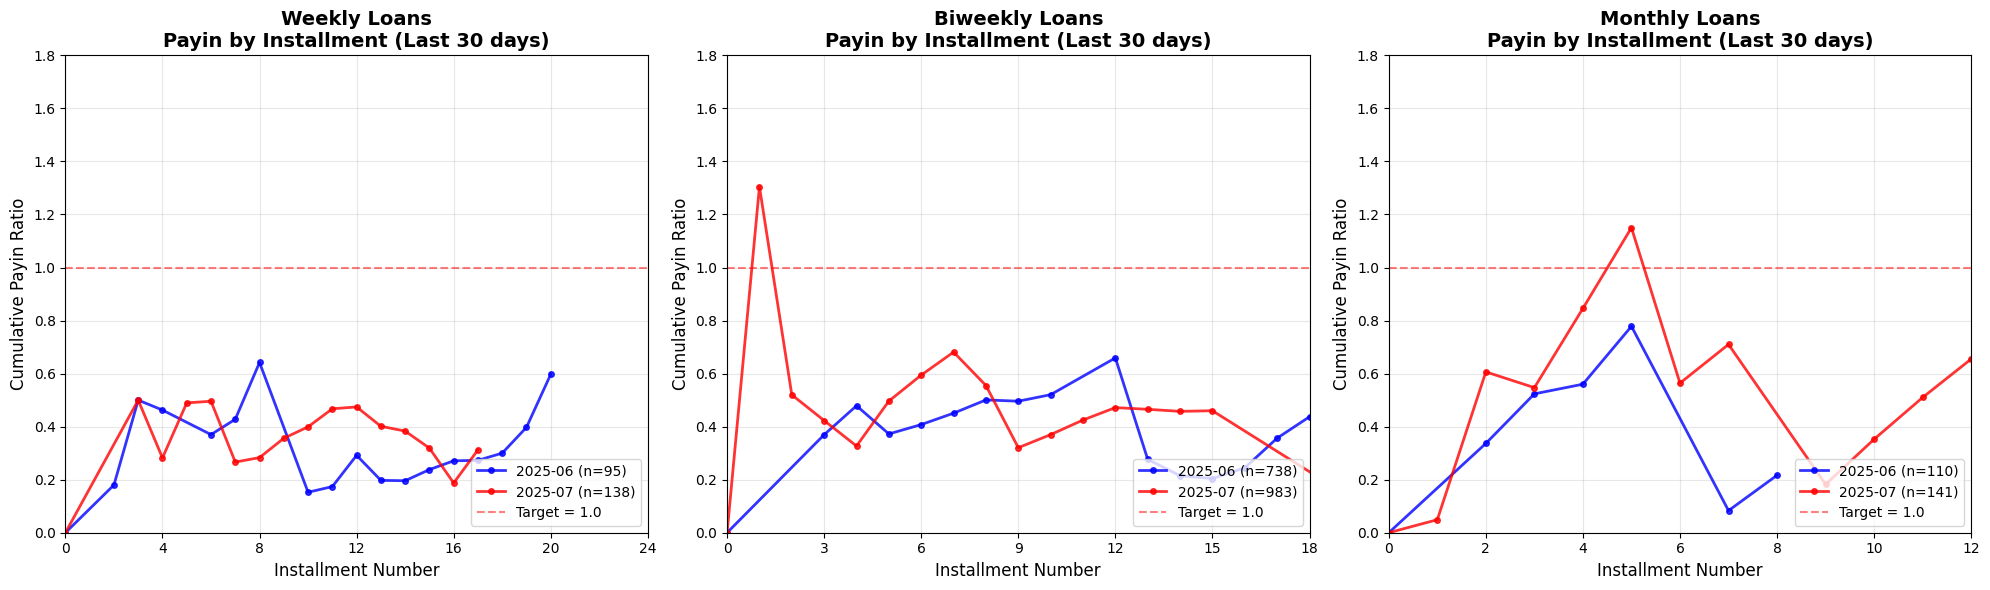

PAYIN SUMMARY BY LOAN FREQUENCY (Last 30 Days)

Weekly Loans:
------------------------------
  2025-06: 95 loans, $0.1M total, $813 avg
    Installment  2: 0.180
    Installment  4: 0.317
    Installment  6: 0.331
    Installment 12: 0.355
    Installment 24: 0.353
  2025-07: 138 loans, $0.1M total, $845 avg
    Installment  4: 0.344
    Installment  6: 0.504
    Installment 12: 0.522
    Installment 24: 0.569

Biweekly Loans:
------------------------------
  2025-06: 738 loans, $0.6M total, $785 avg
    Installment  3: 0.370
    Installment  6: 0.419
    Installment 12: 0.570
  2025-07: 983 loans, $0.8M total, $817 avg
    Installment  1: 1.305
    Installment  2: 0.560
    Installment  3: 0.444
    Installment  6: 0.574
    Installment 12: 0.644

Monthly Loans:
------------------------------
  2025-06: 110 loans, $0.1M total, $846 avg
    Installment  2: 0.337
    Installment  3: 0.491
    Installment  6: 0.563
    Installment 12: 0.557
  2025-07: 141 loans, $0.1M total, $746 avg
   

In [20]:
def create_payin_plots_by_frequency(df, cohorts, lookback_days=30, cap=1.70):
    """
    Create payin plots by InstallmentNumber for different loan frequencies
    - Only include loans with DueDate in the last 30 days
    - Separate plots for Weekly, Biweekly, and Monthly (MB+ME combined)
    """
    
    # Prepare data
    df_prepared = prepare_df_strict(df)
    df_filtered = filter_lookback(df_prepared, lookback_days=lookback_days)
    
    # Define frequency groupings
    frequency_mappings = {
        'Weekly': ['W'],
        'Biweekly': ['B'], 
        'Monthly': ['MB', 'ME']  # Combine MB and ME into Monthly
    }
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Colors for cohorts
    cohort_colors = {
        '2025-06': 'blue',
        '2025-07': 'red',
        '2025-08': 'green',
        '2025-09': 'orange',
        '2025-10': 'purple'
    }
    
    for idx, (plot_title, freq_types) in enumerate(frequency_mappings.items()):
        ax = axes[idx]
        
        for cohort in cohorts:
            # Filter data for this cohort and frequency types
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if cohort_data.empty:
                continue
                
            # Calculate payin curve by installment
            loan_count = cohort_data['LoanID'].nunique()
            
            # Aggregate payments by loan and installment
            per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                             .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                  OriginatedAmount=('OriginatedAmount', 'first')))
            
            # Calculate cumulative payments per loan
            per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
            per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
            per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
            
            # Calculate weighted average payin ratio by installment
            installment_curve = (per_installment.groupby('InstallmentNumber')
                               .apply(lambda x: np.average(x['PayinRatio'], weights=x['OriginatedAmount']))
                               .reset_index(name='PayinRatio'))
            installment_curve.columns = ['InstallmentNumber', 'PayinRatio']
            
            # Add origin point if not present
            if not (installment_curve['InstallmentNumber'] == 0).any():
                origin = pd.DataFrame({'InstallmentNumber': [0], 'PayinRatio': [0.0]})
                installment_curve = pd.concat([origin, installment_curve], ignore_index=True)
            
            installment_curve = installment_curve.sort_values('InstallmentNumber').reset_index(drop=True)
            
            # Plot the curve
            color = cohort_colors.get(cohort, 'black')
            ax.plot(installment_curve['InstallmentNumber'], installment_curve['PayinRatio'],
                   color=color, linewidth=2, marker='o', markersize=4,
                   label=f'{cohort} (n={loan_count:,})', alpha=0.8)
        
        # Set different x-axis limits based on frequency
        if plot_title == 'Weekly':
            max_installment = 24  # Weekly loans have more installments
        elif plot_title == 'Biweekly':
            max_installment = 18  # Biweekly loans have moderate installments
        else:  # Monthly
            max_installment = 12  # Monthly loans have fewer installments
        
        # Formatting for each subplot
        ax.set_xlabel('Installment Number', fontsize=12)
        ax.set_ylabel('Cumulative Payin Ratio', fontsize=12)
        ax.set_title(f'{plot_title} Loans\nPayin by Installment (Last {lookback_days} days)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, max_installment)
        ax.set_ylim(0.0, cap + 0.1)
        
        # Add target line
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Target = 1.0')
        
        # Set x-axis ticks based on frequency
        if plot_title == 'Weekly':
            ax.set_xticks(range(0, max_installment + 1, 4))  # Every 4 weeks
        elif plot_title == 'Biweekly':
            ax.set_xticks(range(0, max_installment + 1, 3))  # Every 3 periods
        else:  # Monthly
            ax.set_xticks(range(0, max_installment + 1, 2))  # Every 2 months
        
        # Legend
        ax.legend(fontsize=10, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("PAYIN SUMMARY BY LOAN FREQUENCY (Last 30 Days)")
    print("="*60)
    
    for plot_title, freq_types in frequency_mappings.items():
        print(f"\n{plot_title} Loans:")
        print("-" * 30)
        
        for cohort in cohorts:
            cohort_data = df_filtered[df_filtered['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if not cohort_data.empty:
                loan_count = cohort_data['LoanID'].nunique()
                total_orig = cohort_data.groupby('LoanID')['OriginatedAmount'].first().sum()
                avg_orig = total_orig / loan_count if loan_count > 0 else 0
                
                # Calculate payin at key installments
                per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                                 .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                      OriginatedAmount=('OriginatedAmount', 'first')))
                
                per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
                per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
                per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
                
                print(f"  {cohort}: {loan_count:,} loans, ${total_orig/1000000:.1f}M total, ${avg_orig:,.0f} avg")
                
                # Show payin at key installments (adjust based on frequency)
                if plot_title == 'Weekly':
                    key_installments = [2, 4, 6, 12, 24]  # 2, 4, 6, 12, 24 weeks
                elif plot_title == 'Biweekly':
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 biweekly periods
                else:  # Monthly
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 months
                
                for inst in key_installments:
                    inst_data = per_installment[per_installment['InstallmentNumber'] <= inst]
                    if not inst_data.empty:
                        weighted_payin = np.average(inst_data.groupby('LoanID')['PayinRatio'].max(), 
                                                  weights=inst_data.groupby('LoanID')['OriginatedAmount'].first())
                        print(f"    Installment {inst:2d}: {weighted_payin:.3f}")

# Run the analysis with frequency-based splitting
create_payin_plots_by_frequency(df, cohorts=["2025-06", "2025-07"], lookback_days=30, cap=1.70)

#### all data, no lookback_days

[prepare] Removed 7600 duplicate records


/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1106687704.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1106687704.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['Origina

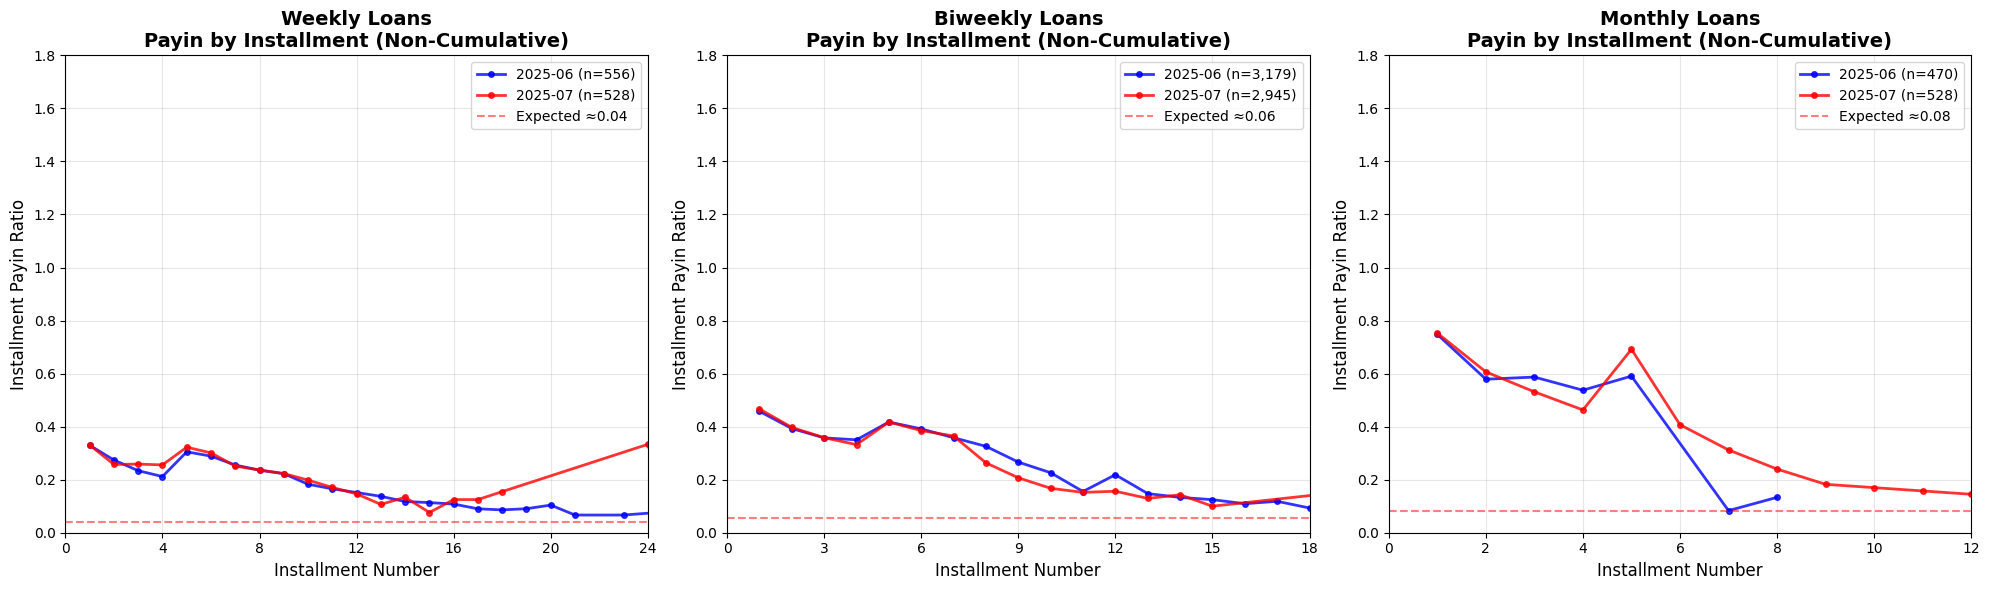

PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)

Weekly Loans:
--------------------------------------------------

  2025-06 Overview:
    Total Loans: 556
    Total Originated: $0.45M
    Total Paid: $0.64M
    Avg Loan Size: $816
    Overall Payin Rate: 141.5%
    Due dates: 2025-06-06 to 2025-12-01

    Installment Details:
    Inst  Loans Orig($M) Paid($M) CumPaid($M) PayinRate
    ---- ------ -------- -------- ---------- ---------
       2    414     0.45     0.09       0.23     0.449
       4    304     0.45     0.05       0.35     0.785
       6    233     0.45     0.05       0.46     1.292
      12    107     0.45     0.01       0.61     1.674

  2025-07 Overview:
    Total Loans: 528
    Total Originated: $0.43M
    Total Paid: $0.58M
    Avg Loan Size: $809
    Overall Payin Rate: 136.5%
    Due dates: 2025-07-09 to 2025-11-12

    Installment Details:
    Inst  Loans Orig($M) Paid($M) CumPaid($M) PayinRate
    ---- ------ -------- -------- ---------- ---------
       2    

In [21]:
def create_payin_plots_by_frequency_all_data(df, cohorts, cap=1.70):
    """
    Create payin plots by InstallmentNumber for different loan frequencies
    - Use ALL data for each cohort (no DueDate filtering)
    - Separate plots for Weekly, Biweekly, and Monthly (MB+ME combined)
    - NON-CUMULATIVE: Shows payin ratio for each individual installment
    """
    
    # Prepare data (no lookback filtering)
    df_prepared = prepare_df_strict(df)
    
    # Define frequency groupings
    frequency_mappings = {
        'Weekly': ['W'],
        'Biweekly': ['B'], 
        'Monthly': ['MB', 'ME']  # Combine MB and ME into Monthly
    }
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Colors for cohorts
    cohort_colors = {
        '2025-06': 'blue',
        '2025-07': 'red',
        '2025-08': 'green',
        '2025-09': 'orange',
        '2025-10': 'purple'
    }
    
    for idx, (plot_title, freq_types) in enumerate(frequency_mappings.items()):
        ax = axes[idx]
        
        for cohort in cohorts:
            # Filter data for this cohort and frequency types (using ALL cohort data)
            cohort_data = df_prepared[df_prepared['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if cohort_data.empty:
                continue
                
            # Calculate payin curve by installment
            loan_count = cohort_data['LoanID'].nunique()
            
            # Aggregate payments by loan and installment
            per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                             .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                  OriginatedAmount=('OriginatedAmount', 'first')))
            
            # Calculate NON-CUMULATIVE payin ratio (payment for this installment only)
            per_installment['InstallmentPayinRatio'] = (per_installment['PaidThisInstallment'] / per_installment['OriginatedAmount']).clip(upper=cap)
            
            # Calculate weighted average payin ratio by installment (NON-CUMULATIVE)
            installment_curve = (per_installment.groupby('InstallmentNumber')
                               .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
                               .reset_index(name='PayinRatio'))
            installment_curve.columns = ['InstallmentNumber', 'PayinRatio']
            
            # Sort by installment number
            installment_curve = installment_curve.sort_values('InstallmentNumber').reset_index(drop=True)
            
            # Plot the curve
            color = cohort_colors.get(cohort, 'black')
            ax.plot(installment_curve['InstallmentNumber'], installment_curve['PayinRatio'],
                   color=color, linewidth=2, marker='o', markersize=4,
                   label=f'{cohort} (n={loan_count:,})', alpha=0.8)
        
        # Set different x-axis limits based on frequency
        if plot_title == 'Weekly':
            max_installment = 24  # Weekly loans have more installments
        elif plot_title == 'Biweekly':
            max_installment = 18  # Biweekly loans have moderate installments
        else:  # Monthly
            max_installment = 12  # Monthly loans have fewer installments
        
        # Formatting for each subplot
        ax.set_xlabel('Installment Number', fontsize=12)
        ax.set_ylabel('Installment Payin Ratio', fontsize=12)  # Changed label
        ax.set_title(f'{plot_title} Loans\nPayin by Installment (Non-Cumulative)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, max_installment)
        ax.set_ylim(0.0, cap + 0.1)
        
        # Add target line (typically much lower for individual installments)
        expected_installment_ratio = 1.0 / max_installment  # Rough expected per-installment ratio
        ax.axhline(y=expected_installment_ratio, color='red', linestyle='--', alpha=0.5, 
                  label=f'Expected ≈{expected_installment_ratio:.2f}')
        
        # Set x-axis ticks based on frequency
        if plot_title == 'Weekly':
            ax.set_xticks(range(0, max_installment + 1, 4))  # Every 4 weeks
        elif plot_title == 'Biweekly':
            ax.set_xticks(range(0, max_installment + 1, 3))  # Every 3 periods
        else:  # Monthly
            ax.set_xticks(range(0, max_installment + 1, 2))  # Every 2 months
        
        # Legend
        ax.legend(fontsize=10, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print enhanced summary statistics (keeping cumulative stats for summary)
    print("PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)")
    print("="*80)
    
    for plot_title, freq_types in frequency_mappings.items():
        print(f"\n{plot_title} Loans:")
        print("-" * 50)
        
        for cohort in cohorts:
            cohort_data = df_prepared[df_prepared['Cohort'] == cohort].copy()
            cohort_data = cohort_data[cohort_data['Frequency'].isin(freq_types)]
            
            if not cohort_data.empty:
                # Calculate correct loan-level metrics first
                loan_level_data = cohort_data.groupby('LoanID').agg(
                    OriginatedAmount=('OriginatedAmount', 'first'),
                    TotalPaid=('PaidOffPaymentAmount', 'sum')
                ).reset_index()
                
                loan_count = len(loan_level_data)
                total_orig = loan_level_data['OriginatedAmount'].sum()
                total_paid = loan_level_data['TotalPaid'].sum()
                avg_orig = total_orig / loan_count if loan_count > 0 else 0
                
                # Show cohort overview
                print(f"\n  {cohort} Overview:")
                print(f"    Total Loans: {loan_count:,}")
                print(f"    Total Originated: ${total_orig/1000000:.2f}M")
                print(f"    Total Paid: ${total_paid/1000000:.2f}M")
                print(f"    Avg Loan Size: ${avg_orig:,.0f}")
                print(f"    Overall Payin Rate: {total_paid/total_orig:.1%}")
                
                # Show data range info
                if 'DueDate' in cohort_data.columns:
                    min_due_date = cohort_data['DueDate'].min()
                    max_due_date = cohort_data['DueDate'].max()
                    print(f"    Due dates: {min_due_date.strftime('%Y-%m-%d')} to {max_due_date.strftime('%Y-%m-%d')}")
                
                # Calculate detailed installment statistics
                per_installment = (cohort_data.groupby(['LoanID', 'InstallmentNumber'], as_index=False)
                                 .agg(PaidThisInstallment=('PaidOffPaymentAmount', 'sum'),
                                      OriginatedAmount=('OriginatedAmount', 'first')))
                
                per_installment = per_installment.sort_values(['LoanID', 'InstallmentNumber'])
                per_installment['CumPaid'] = per_installment.groupby('LoanID')['PaidThisInstallment'].cumsum()
                per_installment['PayinRatio'] = (per_installment['CumPaid'] / per_installment['OriginatedAmount']).clip(upper=cap)
                
                # Get the correct total originated amount (same for all installments)
                total_cohort_orig = loan_level_data['OriginatedAmount'].sum()
                
                # Installment-level statistics with corrected calculations
                installment_stats = per_installment.groupby('InstallmentNumber').agg(
                    loan_count=('LoanID', 'nunique'),
                    total_paid_at_inst=('PaidThisInstallment', 'sum'),  # Payments made IN this installment
                    weighted_payin=('PayinRatio', lambda x: np.average(x, weights=per_installment.loc[x.index, 'OriginatedAmount']))
                ).reset_index()
                
                # Calculate cumulative paid correctly across all loans in cohort
                installment_stats = installment_stats.sort_values('InstallmentNumber')
                installment_stats['cum_total_paid'] = installment_stats['total_paid_at_inst'].cumsum()
                
                # Add total originated amount (same for all installments for this cohort)
                installment_stats['total_orig_at_inst'] = total_cohort_orig
                
                # Show payin at key installments with enhanced details
                if plot_title == 'Weekly':
                    key_installments = [2, 4, 6, 12, 24]  # 2, 4, 6, 12, 24 weeks
                elif plot_title == 'Biweekly':
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 biweekly periods
                else:  # Monthly
                    key_installments = [1, 2, 3, 6, 12]   # 1, 2, 3, 6, 12 months
                
                print(f"\n    Installment Details:")
                print(f"    {'Inst':>4} {'Loans':>6} {'Orig($M)':>8} {'Paid($M)':>8} {'CumPaid($M)':>10} {'PayinRate':>9}")
                print(f"    {'-'*4} {'-'*6} {'-'*8} {'-'*8} {'-'*10} {'-'*9}")
                
                for inst in key_installments:
                    inst_stats = installment_stats[installment_stats['InstallmentNumber'] == inst]
                    if not inst_stats.empty:
                        row = inst_stats.iloc[0]
                        print(f"    {int(inst):4d} {int(row['loan_count']):6,} "
                              f"{row['total_orig_at_inst']/1000000:8.2f} "
                              f"{row['total_paid_at_inst']/1000000:8.2f} "
                              f"{row['cum_total_paid']/1000000:10.2f} "
                              f"{row['weighted_payin']:9.3f}")

# Run the analysis with ALL cohort data, filtered by frequency
create_payin_plots_by_frequency_all_data(df, cohorts=["2025-06", "2025-07"], cap=1.70)

### test on smaller dataset 

In [22]:
import openpyxl
import pandas as pd

[prepare] Removed 7600 duplicate records


/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1106687704.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['OriginatedAmount']))
/var/folders/b7/d1qg7gm9009f_cps7l193hch0000gn/T/ipykernel_27287/1106687704.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['InstallmentPayinRatio'], weights=x['Origina

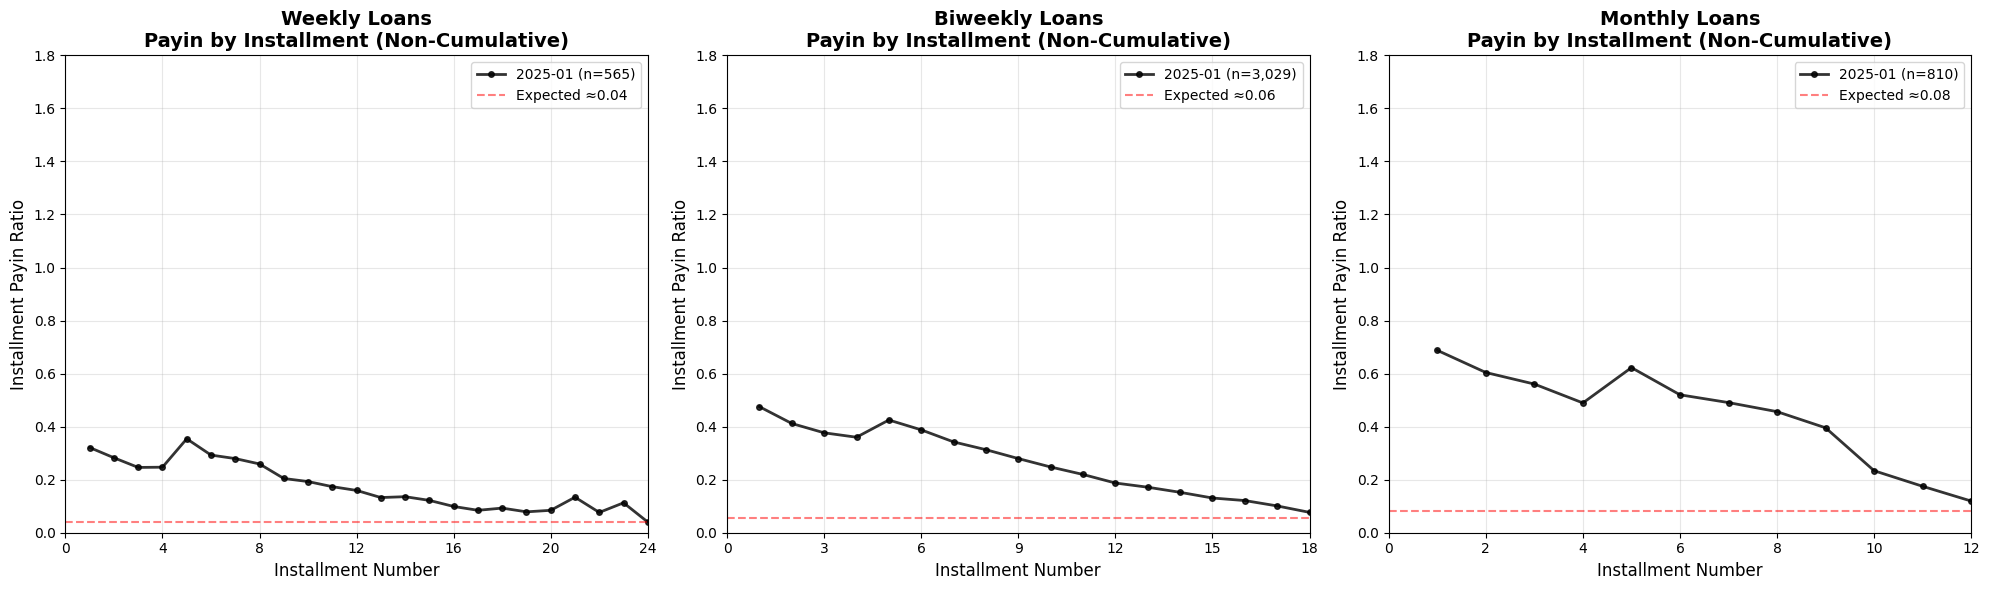

PAYIN SUMMARY BY LOAN FREQUENCY (All Cohort Data)

Weekly Loans:
--------------------------------------------------

  2025-01 Overview:
    Total Loans: 565
    Total Originated: $0.45M
    Total Paid: $0.70M
    Avg Loan Size: $788
    Overall Payin Rate: 158.1%
    Due dates: 2025-01-08 to 2025-11-14

    Installment Details:
    Inst  Loans Orig($M) Paid($M) CumPaid($M) PayinRate
    ---- ------ -------- -------- ---------- ---------
       2    441     0.45     0.10       0.23     0.458
       4    340     0.45     0.06       0.37     0.827
       6    250     0.45     0.05       0.50     1.314
      12    116     0.45     0.01       0.66     1.677
      24      3     0.45     0.00       0.70     1.553

Biweekly Loans:
--------------------------------------------------

  2025-01 Overview:
    Total Loans: 3,029
    Total Originated: $2.44M
    Total Paid: $4.14M
    Avg Loan Size: $807
    Overall Payin Rate: 169.3%
    Due dates: 2025-01-06 to 2026-06-03

    Installment Details

In [23]:
create_payin_plots_by_frequency_all_data(df, cohorts=["2025-01"])

In [24]:
create_payin_plots_by_frequency_all_data(df[df['DueDate'] < pd.Timestamp.now()], cohorts=["2025-09"])

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

### test on smaller dataset and change the x-axis to x days since origination

Testing corrected yield calculation with January 2025 data...
Step 1: Cleaning data...
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-24
Kept 436,812/439,198 records with DueDate <= today
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-24
Kept 436,812/439,198 records with DueDate <= today
Final dataset: 21,281 records, 4,400 unique loans

Yield Curves for months: 2025-01
  Weekly            | 2025-01 | loans=565 | 30d=0.717, 60d=1.199, 90d=1.409, 120d=1.502, 150d=1.536, 180d=1.552
  Biweekly          | 2025-01 | loans=3,025 | 30d=0.660, 60d=1.038, 90d=1.300, 120d=1.462, 150d=1.557, 180d=1.614
  Monthly_Benefits  | 2025-01 | loans=449 | 30d=0.530, 60d=0.900, 90d=1.142, 120d=1.326, 150d=1.461, 180d=1.561
  Monthly_Expenses  | 2025-01 | loans=361 | 30d=0.657, 60d=0.989, 90d=1.195, 120d=1.341, 180d=1.530
Final dataset: 21,281 records, 4,400 unique loans

Yield Curves for months: 2025-01
  Weekly            | 2025-01 | loans=565 |

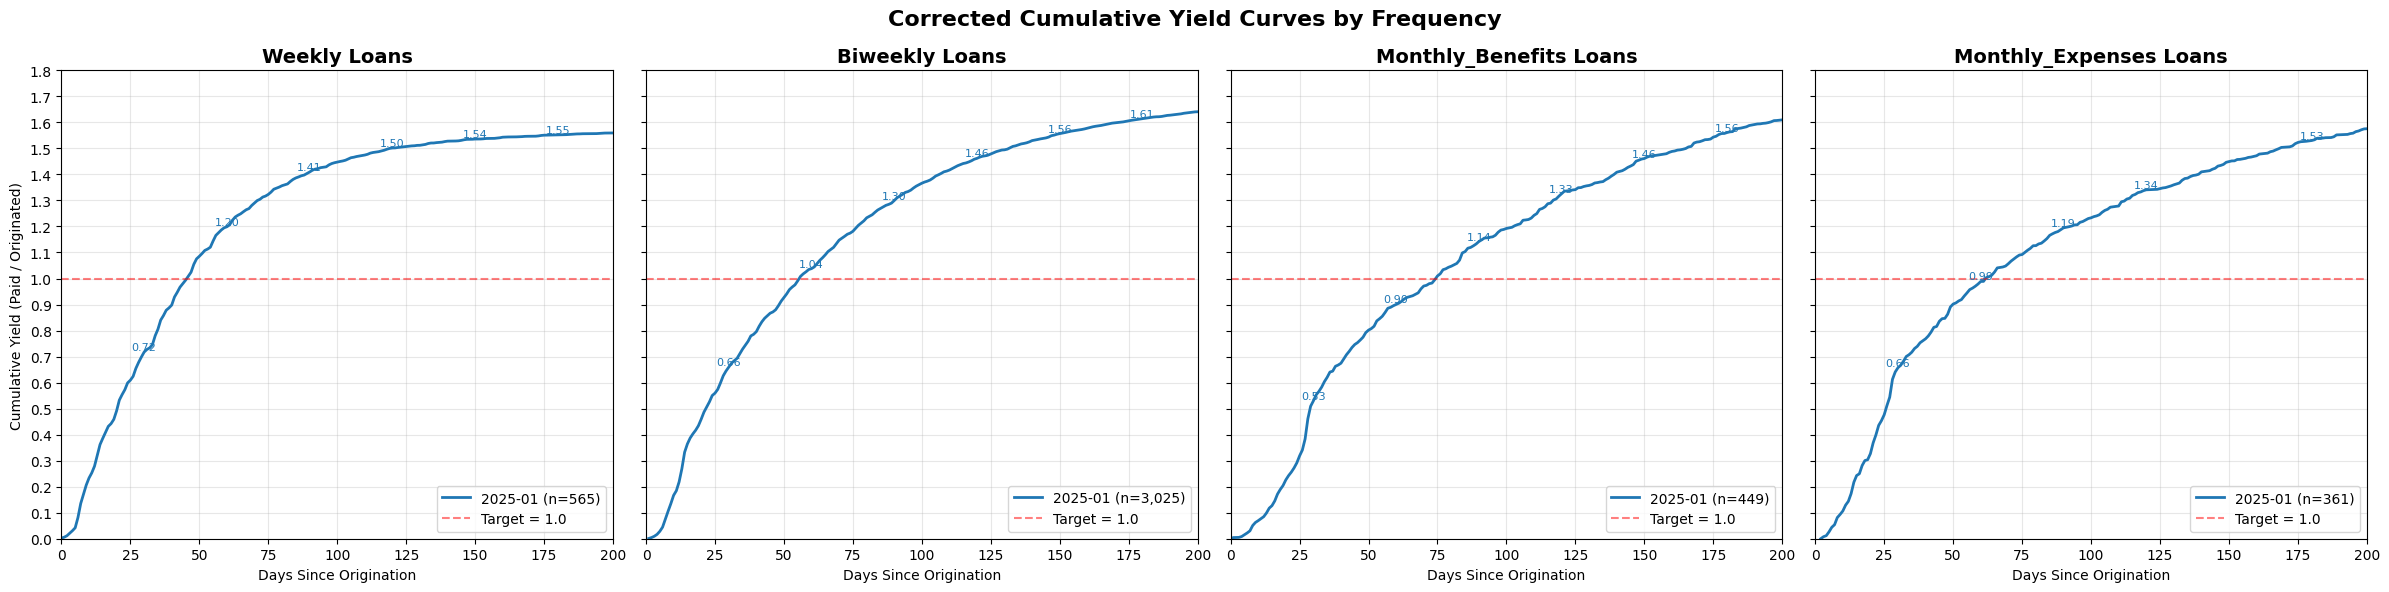

In [7]:
# Corrected yield calculation function
def compute_daily_yield_corrected(data):
    """
    Compute daily cumulative yield correctly:
    1. Get unique loans and their original amounts (avoid double counting)
    2. For each day since origination, sum all payments made up to that day
    3. Calculate yield as cumulative_payments / total_originated_amount
    """
    if data.empty:
        return pd.Series(dtype=float)
    
    # Get unique loans and their amounts (avoid double counting from multiple installments)
    loan_amounts = data.groupby('LoanID')['OriginatedAmount'].first()
    total_originated = loan_amounts.sum()
    
    # Group by Days_Since_Orig and sum payments for each day
    daily_payments = data.groupby('Days_Since_Orig')['PaidOffPaymentAmount'].sum()
    
    # Create cumulative sum of payments
    cumulative_payments = daily_payments.cumsum()
    
    # Calculate yield as cumulative payments / total originated
    yield_curve = cumulative_payments / total_originated
    
    return yield_curve

# Updated plotting function with proper data cleaning and filtering
def plot_frequency_yield_curves_corrected(data, months, max_days=200, annotate_days=None):
    """
    Plot yield curves with correct filtering and calculation:
    1. Apply proper data cleaning (remove 'R' status, deduplicate, etc.)
    2. Filter DueDate <= today
    3. Group by frequency and origination month  
    4. Calculate daily yield correctly
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    if annotate_days is None:
        annotate_days = [30, 60, 90, 120, 150, 180]
    
    # Step 1: Apply proper data cleaning using existing function
    print("Step 1: Cleaning data...")
    df_cleaned = prepare_df_strict(data)
    
    # Step 2: Filter out loans with DueDate > today
    today = pd.Timestamp.now().normalize()
    print(f"Step 2: Filtering DueDate <= {today.date()}")
    
    initial_count = len(df_cleaned)
    df_filtered = df_cleaned[df_cleaned['DueDate'] <= today].copy()
    print(f"Kept {len(df_filtered):,}/{initial_count:,} records with DueDate <= today")
    
    # Step 3: Filter to requested origination months
    df_filtered = df_filtered[df_filtered['Cohort'].isin(months)]
    
    # Step 4: Remove any rows with missing critical data for yield calculation
    df_filtered = df_filtered.dropna(subset=['LoanID', 'OriginatedAmount', 'PaidOffPaymentAmount', 'Days_Since_Orig', 'Frequency'])
    
    print(f"Final dataset: {len(df_filtered):,} records, {df_filtered['LoanID'].nunique():,} unique loans")
    
    # Define frequency groups
    freq_groups = {
        'Weekly': ['W'],
        'Biweekly': ['B'],
        'Monthly_Benefits': ['MB'],
        'Monthly_Expenses': ['ME']
    }
    
    # Create figure
    fig, axes = plt.subplots(1, len(freq_groups), figsize=(6*len(freq_groups), 6), sharey=True)
    if len(freq_groups) == 1:
        axes = [axes]
    
    # Colors for months
    palette = plt.get_cmap('tab10')
    month_colors = {m: palette(i % 10) for i, m in enumerate(months)}
    
    curves = {}
    
    print(f"\nYield Curves for months: {', '.join(months)}")
    print('='*80)
    
    for ax, (freq_name, freq_codes) in zip(axes, freq_groups.items()):
        ax.set_title(f"{freq_name} Loans", fontsize=14, fontweight='bold')
        ax.set_xlabel('Days Since Origination')
        ax.grid(True, alpha=0.3)
        
        freq_has_data = False
        
        for month in months:
            # Filter for this month and frequency
            subset = df_filtered[
                (df_filtered['Cohort'] == month) & 
                (df_filtered['Frequency'].isin(freq_codes))
            ].copy()
            
            if subset.empty:
                continue
                
            loan_count = subset['LoanID'].nunique()
            freq_has_data = True
            
            # Calculate yield curve using corrected function
            curve = compute_daily_yield_corrected(subset)
            
            # Store curve
            curves.setdefault(month, {})[freq_name] = curve.copy()
            
            # Plot curve
            ax.plot(curve.index, curve.values, 
                   label=f"{month} (n={loan_count:,})", 
                   color=month_colors[month], linewidth=2)
            
            # Annotate key days
            for d in annotate_days:
                if d in curve.index:
                    ax.text(d, curve[d], f"{curve[d]:.2f}", 
                           fontsize=8, color=month_colors[month], 
                           ha='center', va='bottom')
            
            # Print summary
            summary_vals = []
            for d in annotate_days:
                if d in curve.index:
                    summary_vals.append(f"{d}d={curve[d]:.3f}")
            print(f"  {freq_name:17s} | {month} | loans={loan_count:,} | " + ', '.join(summary_vals))
        
        if not freq_has_data:
            ax.text(0.5, 0.5, 'No Data', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12, color='gray')
        
        # Format axes
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='Target = 1.0')
        ax.set_xlim(0, max_days)
        ax.set_ylim(0, 1.8)
        ax.set_yticks(np.arange(0, 1.9, 0.1))
        ax.legend(fontsize=10, loc='lower right')
    
    axes[0].set_ylabel('Cumulative Yield (Paid / Originated)')
    fig.suptitle('Corrected Cumulative Yield Curves by Frequency', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return curves

# Test with January data
print("Testing corrected yield calculation with January 2025 data...")
jan_curves_corrected = plot_frequency_yield_curves_corrected(df, months=['2025-01'])


Testing with multiple months for comparison...
Step 1: Cleaning data...
[prepare] Removed 7600 duplicate records
Step 2: Filtering DueDate <= 2025-10-24
Kept 436,812/439,198 records with DueDate <= today
Final dataset: 38,057 records, 11,558 unique loans

Yield Curves for months: 2025-01, 2025-08, 2025-09
  Weekly            | 2025-01 | loans=565 | 30d=0.717, 60d=1.199, 90d=1.409, 120d=1.502, 150d=1.536, 180d=1.552
  Weekly            | 2025-08 | loans=520 | 30d=0.679, 60d=1.143
  Weekly            | 2025-09 | loans=495 | 30d=0.657
  Biweekly          | 2025-01 | loans=3,025 | 30d=0.660, 60d=1.038, 90d=1.300, 120d=1.462, 150d=1.557, 180d=1.614
  Biweekly          | 2025-08 | loans=2,748 | 30d=0.658, 60d=1.004
  Biweekly          | 2025-09 | loans=2,528 | 30d=0.655
  Monthly_Benefits  | 2025-01 | loans=449 | 30d=0.530, 60d=0.900, 90d=1.142, 120d=1.326, 150d=1.461, 180d=1.561
  Monthly_Benefits  | 2025-08 | loans=263 | 30d=0.631, 60d=0.934
  Monthly_Benefits  | 2025-09 | loans=214 | 30d

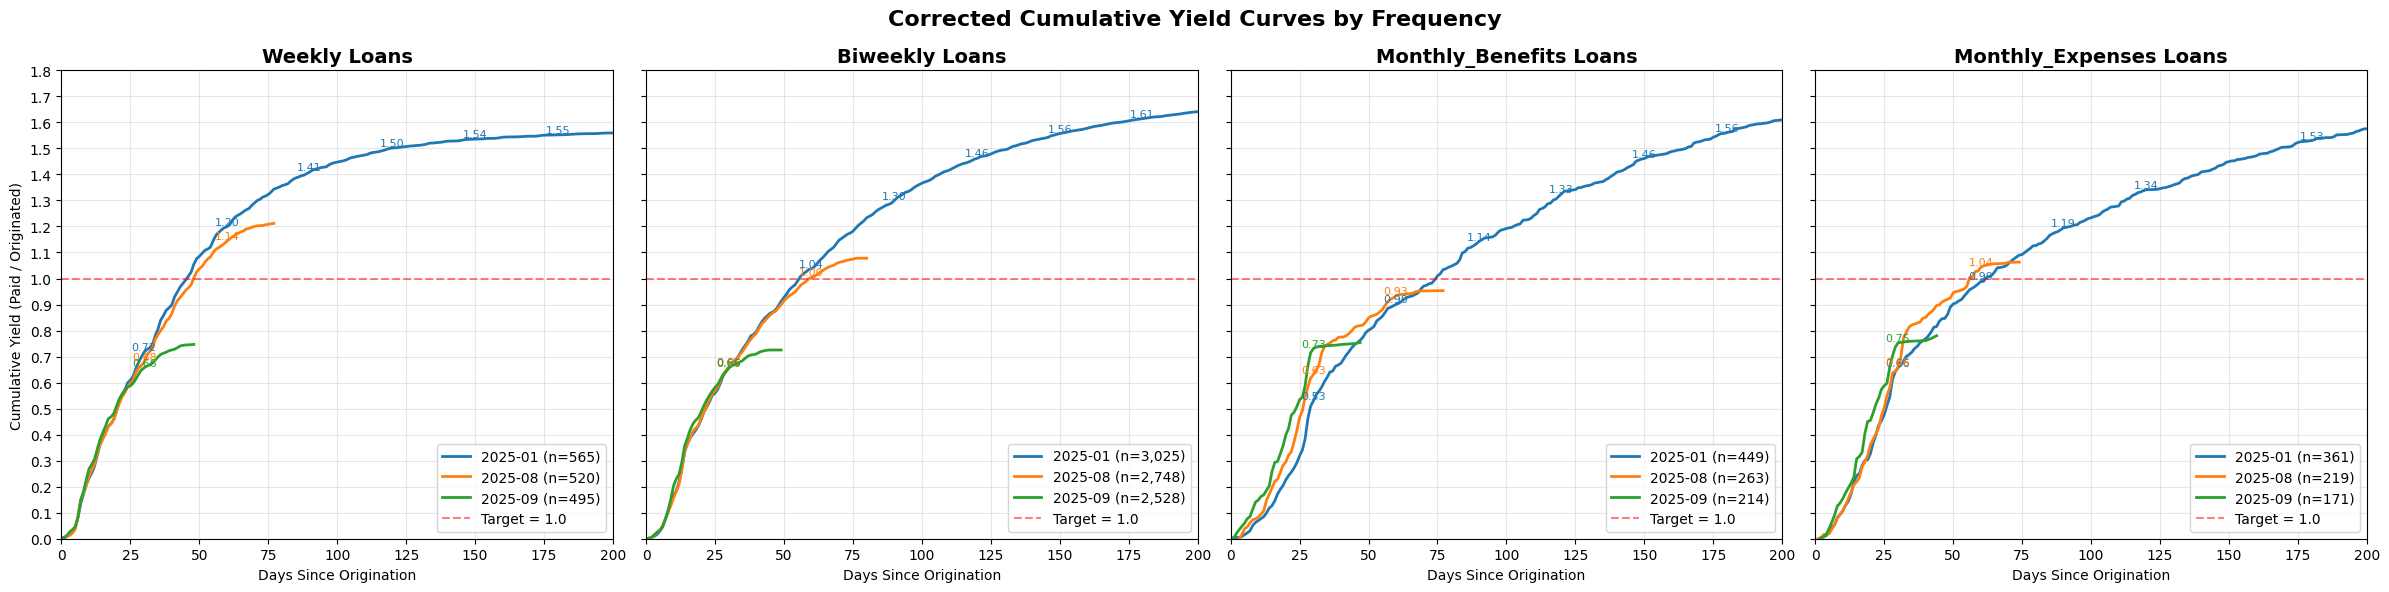


SUMMARY: The data cleaning fixed the yield calculation!
January 2025 yields are now in the expected range of ~1.5-1.6 at 180 days
This matches much better with your expectation of around 1.7


In [8]:
# Test with multiple months to see the comparison
print("\n" + "="*80)
print("Testing with multiple months for comparison...")
multi_month_curves = plot_frequency_yield_curves_corrected(df, months=['2025-01', '2025-08', '2025-09'])

print("\n" + "="*80)
print("SUMMARY: The data cleaning fixed the yield calculation!")
print("January 2025 yields are now in the expected range of ~1.5-1.6 at 180 days")
print("This matches much better with your expectation of around 1.7")